In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create database path
import os
database_path = os.path.join('Resources', 'hawaii.sqlite')

In [6]:
# create engine
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_months = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
    
for date in latest_months:
    most_recent_date = date.date

most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")

# Calculate the date 1 year ago from the last data point in the database
date_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(prcp_data, columns=['date', 'precipitation'])

# Set index to date
precipitation_df .set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)
precipitation_df

,precipitation
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


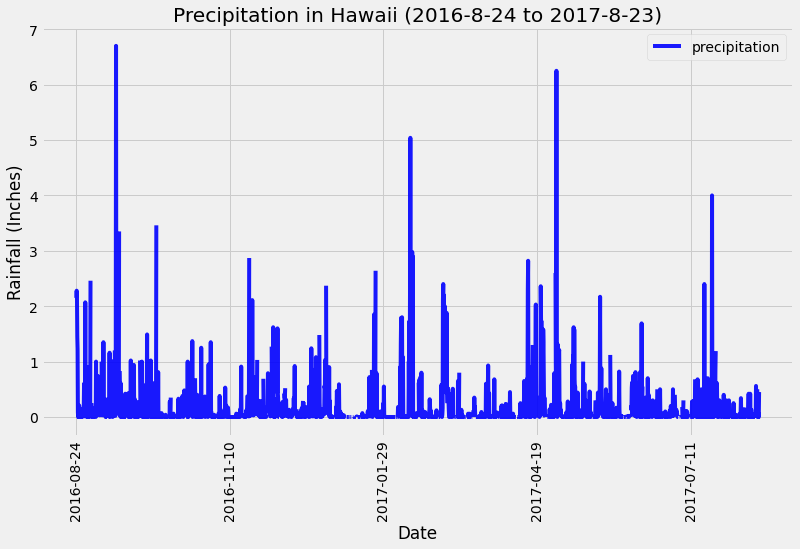

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(12,7), color="blue", alpha=0.9)
plt.title("Precipitation in Hawaii (2016-8-24 to 2017-8-23)")
plt.xlabel("Date")
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation='90')
plt.legend(loc='upper right')
plt.savefig("Images/precipitation.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f"There are {stations} stations in this dataset.")

There are 9 stations in this dataset.


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active_stations = session.query(Measurement.station, 
                        func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for station, count in most_active_stations:
    print(f"Station: {station}, No. of Observations: {count}")

Station: USC00519281, No. of Observations: 2772
Station: USC00519397, No. of Observations: 2724
Station: USC00513117, No. of Observations: 2709
Station: USC00519523, No. of Observations: 2669
Station: USC00516128, No. of Observations: 2612
Station: USC00514830, No. of Observations: 2202
Station: USC00511918, No. of Observations: 1979
Station: USC00517948, No. of Observations: 1372
Station: USC00518838, No. of Observations: 511


In [31]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station=most_active_stations[0][0]
most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).all()
print(f"Temperatures at the Most Active Station, No. {most_active_station}:")
print(f"Lowest = {round(most_active_temps[0][0], 1)} F, Highest = {round(most_active_temps[0][1], 1)} F, Average = {round(most_active_temps[0][2], 1)} F")

Temperatures at the Most Active Station, No. USC00519281:
Lowest = 54.0 F, Highest = 85.0 F, Average = 71.7 F


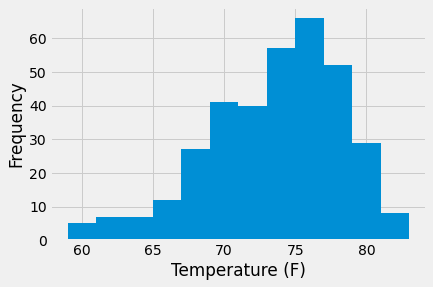

In [33]:
# Choose the station with the highest number of temperature observations.
active_station_data = session.query(Measurement.tobs).filter(Measurement.station==most_active_station).filter(Measurement.date >= date_year_ago).order_by(Measurement.date.desc()).all()

x = [x[0] for x in active_station_data]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(x, bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.savefig("Images/temperature_histogram.png")
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
